In [2]:
import json, random, time
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load the network graph and the user comments list

In [3]:
with open("network.json") as f_in:
    network_map = json.load(f_in)

In [4]:
g = nx.DiGraph()
for key, value in network_map.items():
    from_user = key
    for k, v in value.items():
        to_user = k
        weight = v
        g.add_edge(from_user, to_user, weight = weight)

# remove instances of "[deleted]" from the network
g.remove_node('[deleted]')

## Get Overall Graph Statistics

In [5]:
%%time
# pull these up now so we can just pull nodes from them as we get them
g_degree_centrality = nx.degree_centrality(g)
g_in_degree_centrality = nx.in_degree_centrality(g)
g_out_degree_centrality = nx.out_degree_centrality(g)
g_avg_neighbor_degree = nx.average_neighbor_degree(g)
g_pagerank = nx.pagerank(g)

Wall time: 32.6 s


In [31]:
%%time
# http://www.educa.fmf.uni-lj.si/datana/pub/networks/pajek/triade.pdf
g_triadic_census = nx.triadic_census(g)

Wall time: 5min 11s


In [32]:
g_triadic_census

{'003': 13779422173036609,
 '012': 242678602077,
 '102': 73443781170,
 '021D': 1751047,
 '021U': 2011446,
 '021C': 2134966,
 '111D': 1440234,
 '111U': 2002341,
 '030T': 20055,
 '030C': 3843,
 '201': 2062777,
 '120D': 7119,
 '120U': 8902,
 '120C': 10914,
 '210': 14856,
 '300': 4488}

## Get Individual Node Measures

In [13]:
def get_node_stats(node, triads=False):
    r = {}
    r['degree'] = g.degree[node]
    
    # get the ego graph for this node
    radius = 3
    if r['degree'] > 200:
        radius = 2
    ego = nx.ego_graph(g, node, radius=radius)
    
    # save this node's name
    r['node'] = node
    
    r['avg_clustering'] = nx.average_clustering(nx.Graph(ego))
    r['ego_density'] = nx.density(ego)
    
    # edge measures
    r['avg_neighbor_degree'] = g_avg_neighbor_degree[node]
    in_edges = g.in_edges(node, data=True)
    out_edges = g.out_edges(node, data=True)
    r['in_degree'] = len(in_edges)
    r['out_degree'] = len(out_edges)
    r['sum_in_edge_weight'] = sum([edge[2]['weight'] for edge in in_edges])
    r['sum_out_edge_weight'] = sum([edge[2]['weight'] for edge in out_edges])
    r['avg_in_edge_weight'] = np.mean([edge[2]['weight'] for edge in in_edges])
    r['avg_out_edge_weight'] = np.mean([edge[2]['weight'] for edge in out_edges])
    
    if len(ego) > 1:
        r['reciprocity'] = nx.reciprocity(nx.ego_graph(g, node))
    else:
        r['reciprocity'] = 0
    
    # centrality
    r['degree_centrality'] = g_degree_centrality[node]
    r['in_degree_centrality'] = g_in_degree_centrality[node]
    r['out_degree_centrality'] = g_out_degree_centrality[node]
    
    r['pagerank'] = g_pagerank[node]
    
    if not triads:
        return r
    
    # randomly sample the ego graph if it contains more than 200 nodes
    if len(ego) > 200:
        ego = nx.subgraph(g, random.sample([n for n in ego], k=min(200, len(ego))))
    
    # triad counts/ratios
    triads = nx.triadic_census(ego)
    s = max(sum(triads.values()),1)
    triad_ratios = {str(k)+"_ratio":v/s for (k,v) in triads.items()}
    
    return {**r, **triads, **triad_ratios}

In [16]:
%%timeit
## test avg execution time
node = random.choice(bot_df.author.unique())
try:
    get_node_stats(node, triads=True)
except Exception as e:
    pass

F:\Programs\Anaconda\envs\si618\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
F:\Programs\Anaconda\envs\si618\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


399 ms ± 194 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Load the user and bot comments data

In [8]:
user_df = pd.read_csv("user_comments.csv")

In [9]:
# From Yi's code
import glob
allFiles = glob.glob("bot_comments" + "*.csv")
bot_df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    if "1" in file_:
        df = pd.read_csv(file_,index_col = None, header = None)
    else:
        df = pd.read_csv(file_,index_col = None, header = None)
    list_.append(df)
bot_df = pd.concat(list_)
bot_df.columns = ['author', 'created_utc', 'link_id', 'parent_id', 'score', 'id','subreddit']
bot_df = bot_df[bot_df['author'] != "author"]

F:\Programs\Anaconda\envs\si618\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
# combine them in a single df
combined_df = pd.concat([bot_df,user_df])

## Iterate through the comments files and get network features

In [ ]:
%%time
# get a list of all the bot usernames
bot_list = bot_df.author.unique()

total_count = len(combined_df.author.unique())
count = 0

results = []
start = time.time()
for user in combined_df.author.unique():
    try:
        results.append({
            **get_node_stats(user, triads=True),
            **{'bot':(0,1)[user in bot_list]}
        })
    except Exception as e:
        pass
#         print("Exception: node {}: {}".format(user, e))
    count += 1
    if count % 100 == 0:
        print("{} of {} ({:.4f} s/row)".format(count, total_count, (time.time()-start)/100))
        start = time.time()
        pd.DataFrame(results).to_csv("node_measures_w_triads.csv", index=None)

### Testing how much I can sample the ego graph of a random node

In [131]:
def sample_ego_comp(node, k):
    ego = nx.ego_graph(g, node, radius=2)
    
    k = min(k, len(ego))

    triads = nx.triadic_census(ego)
    s = max(sum(triads.values()),1)
    ego_triads = {k:v/s for (k,v) in triads.items()}

    sampled_ego = nx.subgraph(g, random.sample([n for n in ego], k=k))

    triads = nx.triadic_census(sampled_ego)
    s = max(sum(triads.values()),1)
    sampled_ego_triads = {k:v/s for (k,v) in triads.items()}

    return np.mean([abs(v - sampled_ego_triads[k]) for k,v in ego_triads.items()])

results = []
for node in random.sample(list(combined_df.author.unique()), k=400):
    try:
        for k in range(50, 550, 50):
            comp_result = sample_ego_comp(node, k)
            if comp_result > 0:
                results.append({
                    "k":k,
                    "diff":comp_result
                })
    except:
        pass

results = pd.DataFrame(results)

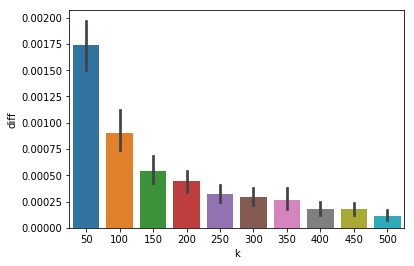

In [155]:
sns.barplot(x=results.k, y=results['diff'])

# Results of running node measures

In [24]:
results = pd.read_csv("node_measures.csv")
results.set_index("node", inplace=True)

In [42]:
results[results.bot==0].sample(5)

,avg_clustering,avg_in_edge_weight,avg_neighbor_degree,avg_out_edge_weight,bot,degree,degree_centrality,ego_density,in_degree,in_degree_centrality,out_degree,out_degree_centrality,pagerank,reciprocity,sum_in_edge_weight,sum_out_edge_weight
node,,,,,,,,,,,,,,,,
Syntheticlullabies,0.000000,NaN,0.0,1.0,0,1,0.000002,0.500000,0,0.000000,1,0.000002,6.421734e-07,0.0,0,1
ActNGreezy,0.000000,NaN,1.0,1.0,0,1,0.000002,0.144444,0,0.000000,1,0.000002,6.421734e-07,0.0,0,1
n00bRekr,0.265125,NaN,4.0,1.0,0,1,0.000002,0.073864,0,0.000000,1,0.000002,6.421734e-07,0.0,0,1
NoMansLight,0.078921,1.0,14.0,1.0,0,4,0.000009,0.005324,1,0.000002,3,0.000007,1.750071e-06,0.5,1,3
notepadow,0.000000,1.0,0.0,NaN,0,2,0.000005,0.000000,2,0.000005,0,0.000000,1.940723e-06,0.0,2,0


In [43]:
results[results.bot==1].sample(5)

,avg_clustering,avg_in_edge_weight,avg_neighbor_degree,avg_out_edge_weight,bot,degree,degree_centrality,ego_density,in_degree,in_degree_centrality,out_degree,out_degree_centrality,pagerank,reciprocity,sum_in_edge_weight,sum_out_edge_weight
node,,,,,,,,,,,,,,,,
addedcolor,0.000000,1.0,0.00,NaN,1,8,0.000018,0.000000,8,0.000018,0,0.000000,7.113461e-06,0.000000,8,0
exaccuss,0.230078,1.0,8.00,1.0,1,2,0.000005,0.005557,1,0.000002,1,0.000002,1.245755e-06,0.000000,1,1
QuickNPainful,0.000000,1.0,0.00,NaN,1,1,0.000002,0.000000,1,0.000002,0,0.000000,8.373051e-07,0.000000,1,0
goosepills,0.152381,1.0,60.20,1.0,1,8,0.000018,0.000665,3,0.000007,5,0.000011,2.173722e-06,0.444444,3,5
opfeels,0.162473,1.2,3.75,1.0,1,17,0.000039,0.001838,5,0.000011,12,0.000028,2.865207e-06,0.444444,6,12


In [44]:
results.groupby("bot").mean()

,avg_clustering,avg_in_edge_weight,avg_neighbor_degree,avg_out_edge_weight,degree,degree_centrality,ego_density,in_degree,in_degree_centrality,out_degree,out_degree_centrality,pagerank,reciprocity,sum_in_edge_weight,sum_out_edge_weight
bot,,,,,,,,,,,,,,,
0,0.065755,1.156338,11.876183,1.134232,4.069020,0.000009,0.124873,2.038316,0.000005,2.030704,0.000005,0.000002,0.310282,2.411034,2.401371
1,0.108254,4.613528,63.465307,33.478922,16.117407,0.000037,0.040080,7.215926,0.000017,8.901480,0.000020,0.000006,0.333811,49.769270,51.909137
